# Functional API

*This is a companion notebook for the excellent book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) ([code provided by François Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks)).* 

The Sequential model is easy to use, but its applicability is extremely limited: it can
only express models with a single input and a single output, applying one layer after
the other in a sequential fashion. 

In practice, it’s pretty common to encounter models
with multiple inputs (say, an image and its metadata), multiple outputs (different
things you want to predict about the data), or a nonlinear topology. In such cases, you’d build your model using the Functional API. 

## Setup

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

## Simple example

A simple Functional model with two `Dense` layers:

In [9]:
# Declare an input (sample has shape 3,1)
inputs = keras.Input(shape=(3,), name="my_input")

# Create a layer and call it on the input
features = layers.Dense(64, activation="relu")(inputs)

# Create final output layer and call it on the features
outputs = layers.Dense(10, activation="softmax")(features)

# Specify inputs and outputs in the Model constructor
model = keras.Model(inputs=inputs, outputs=outputs)

Let's take a look at the objects:

In [10]:
inputs.shape

TensorShape([None, 3])

- The number of samples per batch is variable (indicated by the `None` batch size).
- The model will process batches where each sample has shape `(3,)` (wich is the same as `(3,1)`).

In [11]:
inputs.dtype

tf.float32

- The batches will have dtype `float32`. 

We call such an object a symbolic tensor. It doesn’t contain any actual data, but it
encodes the specifications of the actual tensors of data that the model will see when
you use it. It stands for future tensors of data.

In [12]:
features.shape

TensorShape([None, 64])

Summary of the model:

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


## Multi-input, multi-output

Unlike the previous toy model, most deep learning models don’t look like lists—they look like
graphs. They may, for instance, have multiple inputs or multiple outputs. It’s for this kind of model that the Functional API really shines. 

Let’s say you’re building a system to rank customer support tickets by priority and route them to the appropriate department. 

**Your model has three inputs:**

1. The title of the ticket (text input)
1. The text body of the ticket (text input)
1. Any tags added by the user (categorical input, assumed here to be one-hot
encoded)

We can encode the text inputs as arrays of ones and zeros of size `vocabulary_size`

**Your model also has two outputs:**

- The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
- The department that should handle the ticket (a softmax over the set of departments)

You can build this model in a few lines with the Functional API.

In [14]:
# 1) DEFINE VARIABLES
# Size of vocabulary obtained when preprocessing text data
vocabulary_size = 10000
# Number of unique issue tags
num_tags = 100
# Number of departments for predictions
num_departments = 4

# 2) DEFINE MODEL INPUTS
# Title of tickets
title = keras.Input(shape=(vocabulary_size,), name="title")
# Body of the tickets
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
# Tagy added by user
tags = keras.Input(shape=(num_tags,), name="tags")

# 3) FEATURES
# Combine input 
features = layers.Concatenate()([title, text_body, tags])
# Intermediate layer
features = layers.Dense(64, activation="relu")(features)

# 4) DEFINE MODEL OUTPUTS
# Priority score of the ticket
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
# Department that should handle the ticket
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

# 5) CREATE MODEL
# Specify inputs and outputs
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

### Training

Option 1: Providing lists of input & target arrays

First, we create some random input data with values between 0 and 2 as well as random data for our labels. We will use this data to train our model:

In [18]:
# Define total number of samples
num_samples = 100

# Create random input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# Create random labels
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [19]:
# Compile model
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

# Fit model to data
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

# Evaluate model
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])

# Make predictions
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

4/4 [==============================] - 0s 3ms/step - loss: 55.1070 - priority_loss: 0.3638 - department_loss: 54.7432 - priority_mean_absolute_error: 0.5300 - department_accuracy: 0.2300


Option 2: Providing dicts of input & target arrays

If you don’t want to rely on input order (for instance, because you have many inputs
or outputs), you can also leverage the names you gave to the Input objects and the
output layers, and pass data via dictionaries.

In [20]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

4/4 [==============================] - 0s 3ms/step - loss: 102.1632 - priority_loss: 0.3638 - department_loss: 101.7994 - priority_mean_absolute_error: 0.5300 - department_accuracy: 0.5600


### Access layers

A Functional model is an explicit graph data structure. This makes it possible to
inspect how layers are connected and reuse previous graph nodes (which are layer
outputs) as part of new models. This enables two important use cases: 

- model visualization and 
- feature extraction.

Let’s visualize the connectivity of the model we just defined (the topology of the
model). You can plot a Functional model as a graph with the plot_model():

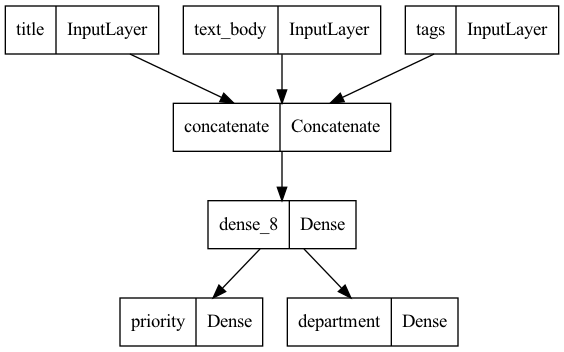

In [21]:
keras.utils.plot_model(model, "ticket_classifier.png")

You can add to this plot the input and output shapes of each layer in the model, which
can be helpful during debugging:

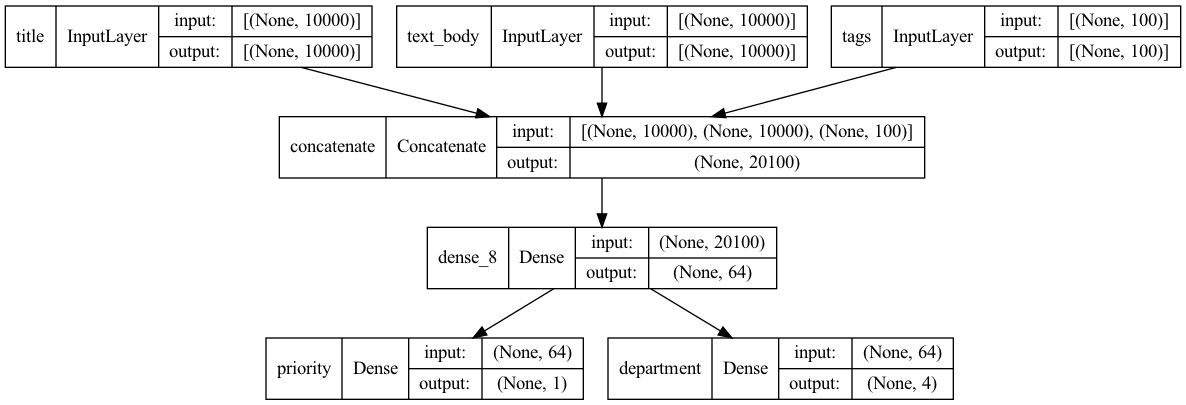

In [22]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

The “None” in the tensor shapes represents the batch size: this model allows batches
of any size.

### Retrieving inputs or outputs

Access to layer connectivity also means that you can inspect and reuse individual
nodes (layer calls) in the graph. The model.layers model property provides the list
of layers that make up the model, and for each layer you can query layer.input and
layer.output

In [23]:
model.layers

In [24]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [25]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

This enables you to do feature extraction, creating models that reuse intermediate features
from another model.
Let’s say you want to add another output to the previous model—you want to estimate
how long a given issue ticket will take to resolve, a kind of difficulty rating. You
could do this via a classification layer over three categories: “quick,” “medium,” and
“difficult.” 

You don’t need to recreate and retrain a model from scratch. You can start
from the intermediate features of your previous model, since you have access to them,
like this.

### Creating a new model

Creating a new model by reusing intermediate layer outputs:

In [26]:
# layers[4] is our intermediate Dense layer
features = model.layers[4].output

difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

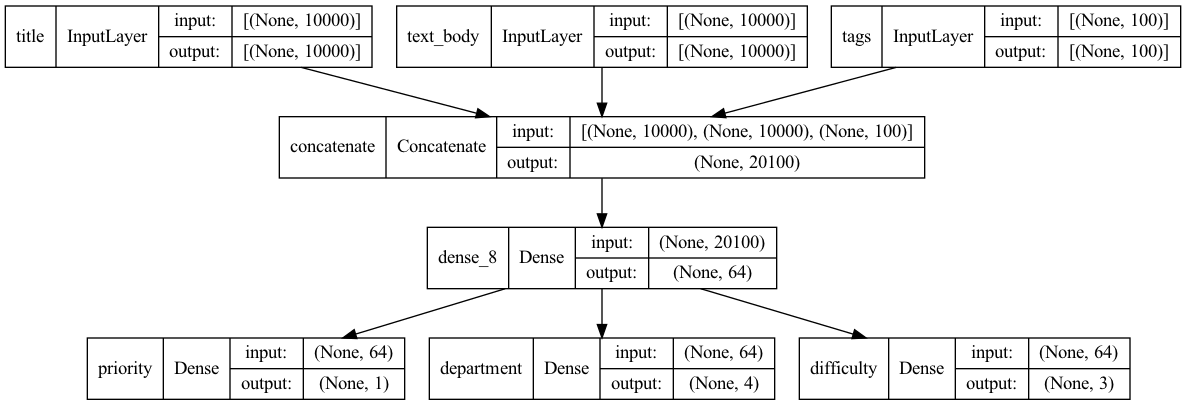

In [27]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)